In [37]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

from boda.models import EfficientDetConfig, EfficientDetModel
from boda.models.efficientdet.utils import Resizer

torch.Size([3, 500, 1000]) <class 'torch.Tensor'>
(512, 512, 3)
label: 2 , score: 1.0


True

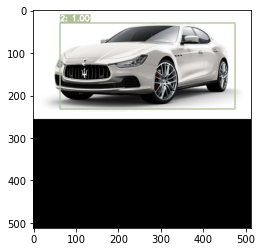

In [62]:
img = cv2.imread('./car.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transforms = A.Compose([
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2(),
])

transformed_img = [transforms(image=img)['image']]

config = EfficientDetConfig()
model = EfficientDetModel(config)
model.load_weights('efficientdet_d0-d92fd44f.pth')
model.eval()

output = model(transformed_img)[0]

boxes, labels, scores = output.values()

img = img.transpose(2, 0, 1)
img = torch.from_numpy(img) / 255.0
print(img.shape, type(img))
img = Resizer()(img)
img = img.numpy().transpose(1, 2, 0)
img = img * 255.0
img = img.astype(np.uint8)
print(img.shape)
img2 = img.copy()

colors = {c: tuple(map(int, np.random.randint(0, 255, 3))) for c in range(90)}

for box, label, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = map(int, box)
    label = label.item()
    score = float(score)
    if score >= 1.0 and label == 2:
        cv2.rectangle(img2, (x1, y1), (x2, y2), colors[label], 2)
        (tw, th), _ = cv2.getTextSize(f'{label}: {score:.2f}', cv2.FONT_HERSHEY_COMPLEX, 0.6, 1)
        cv2.rectangle(img2, (x1, y1-20), (x1+tw, y1), colors[label], -1)
        cv2.putText(img2, f'{label}: {score:.2f}', (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        print('label:', label, ', score:', score)
    
plt.imshow(img2)
cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# cv2.imwrite('./boxed_giraffe.jpg', img2)
# cv2.imwrite('./boxed_giraffe_only.jpg', img2)
# cv2.imwrite('./boxed_giraffe_nonpre.jpg', img2)
# cv2.imwrite('./boxed_car.jpg', img2)
cv2.imwrite('./boxed_only_car.jpg', img2)

torch.Size([3, 558, 930])
(558, 930, 3)


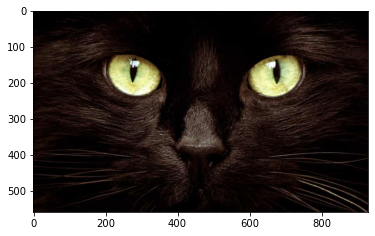

In [49]:
def resize_image_and_masks(
    image,
    self_min_size: float,
    self_max_size: float,
    fixed_size=None,
):
    im_shape = torch.tensor(image.shape[-2:])

    size=None
    scale_factor=None
    recompute_scale_factor=None
    if fixed_size is not None:
        size = [fixed_size[1], fixed_size[0]]
    else:
        min_size = torch.min(im_shape).to(dtype=torch.float32)
        max_size = torch.max(im_shape).to(dtype=torch.float32)
        scale = torch.min(self_min_size / min_size, self_max_size / max_size)
        
        scale_factor = scale.item()
        recompute_scale_factor = True

    image = torch.nn.functional.interpolate(
        image[None],
        size=size,
        scale_factor=scale_factor,
        mode="bilinear",
        recompute_scale_factor=recompute_scale_factor,
        align_corners=False,
    )[0]
    
    return image


image = cv2.imread('./cat_sample.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255.0
image = image.transpose(2, 0, 1)
image = torch.from_numpy(image)
print(image.shape)
image2 = resize_image_and_masks(image, 512., 512., fixed_size=(512, 512))
image2 = image.numpy().transpose(1, 2, 0)
# image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)
print(image2.shape)
plt.imshow(image2)

torch.Size([3, 558, 930])
307 512
torch.Size([3, 307, 512])
torch.Size([3, 512, 512])
(512, 512, 3)


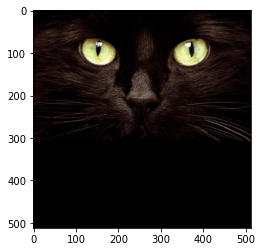

In [34]:
image = cv2.imread('./cat_sample.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255.0
image = image.transpose(2, 0, 1)
_, height, width = image.shape
image = torch.from_numpy(image)
print(image.shape)
img_size = 512
if height > width:
    scale = img_size / height
    resized_height = img_size
    resized_width = int(width * scale)
else:
    scale = img_size / width
    resized_height = int(height * scale)
    resized_width = img_size
print(resized_height, resized_width)
image2 = F.interpolate(
            image[None],
            size=(resized_height, resized_width),
            mode='bilinear',
            align_corners=False,
        )[0]
print(image2.shape)
image3 = torch.zeros((3, img_size, img_size))
image3[:, 0:resized_height, 0:resized_width] = image2
print(image3.shape)
image3 = image3.numpy().transpose(1, 2, 0)
print(image3.shape)
plt.imshow(image3)

(1688, 1125, 3)
(512, 512, 3)


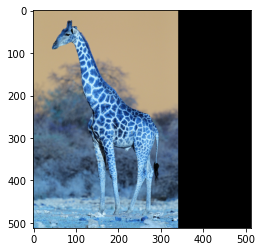

In [53]:
class Resizer(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __init__(self, img_size=512):
        self.img_size = img_size

    def __call__(self, image):
        height, width, _ = image.shape
        if height > width:
            scale = self.img_size / height
            resized_height = self.img_size
            resized_width = int(width * scale)
        else:
            scale = self.img_size / width
            resized_height = int(height * scale)
            resized_width = self.img_size

        image = cv2.resize(image, (resized_width, resized_height), interpolation=cv2.INTER_LINEAR)

        new_image = np.zeros((self.img_size, self.img_size, 3))
        new_image[0:resized_height, 0:resized_width] = image

        return new_image
    
    
image = cv2.imread('./sample_giraffe.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
image2 = Resizer()(image)
print(image2.shape)
image2 = image2 / 255.0
# image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)
plt.imshow(image2)
